\begin{center}
\large{\textbf{UNIVERZITET U BEOGRADU}}\\
[0.26cm]
\textsc\huge{\textbf{ELEKTROTEHNIČKI FAKULTET}}\\
[2cm]
\line(1,0){300}\\
[0.25in]
\LARGE\bfseries{13E044DOS DIGITALNA OBRADE SLIKE}\\
[2mm]
\huge\bfseries{PRVI DOMAĆI}\\
[2mm]
\line(1,0){200}\\
[1.5cm]
\textsc\LARGE{Marko Macura}\\
\LARGE{0261/2018}\\
[7cm]
\textsc{\large{Beograd}}
\end{center}

# Zadatak 1

# Zadatak 2

U ovom zadatku treba klasifikovati novčiće od 1 i od 5 dinara. Pošto je pozadina karakteristične boje i saturacije više od saturacije novčića, prvo sam prebacio kolor sistem u HSV. Koristio sam Otsu-ovu granicu kako bih podelio nijansu. Pošto je pozadina skroz drugačije nijanse od nijanse novčića ovo nije bio problem (videće se kasnije na histogramu). Pošto saturacija nije separabilna kao nijansa, tu nisam mogao da koristim Otsu-ovu granicu, nego sam koristio 0.1 kao granicu. Za novčiće koji su loše klasifikovani nijansom ovo je dobra karakteristika za dalju klasifikaciju. Pošto neki novčići imaju rupe dalje sam radio tako što sam proširio masku, pa je onda skupio kako bi te rupice nestale. Možda bi bilo bolje da sam provukao kroz median filtar, ali sam želeo ovo da probam i dobijam dobre rezultate. 

In [1]:
from pylab import *
import skimage
from skimage import io
from skimage import filters
from skimage import color
from scipy import ndimage
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from tabulate import tabulate

Text(0.5, 1.0, 'Krajnja maska')

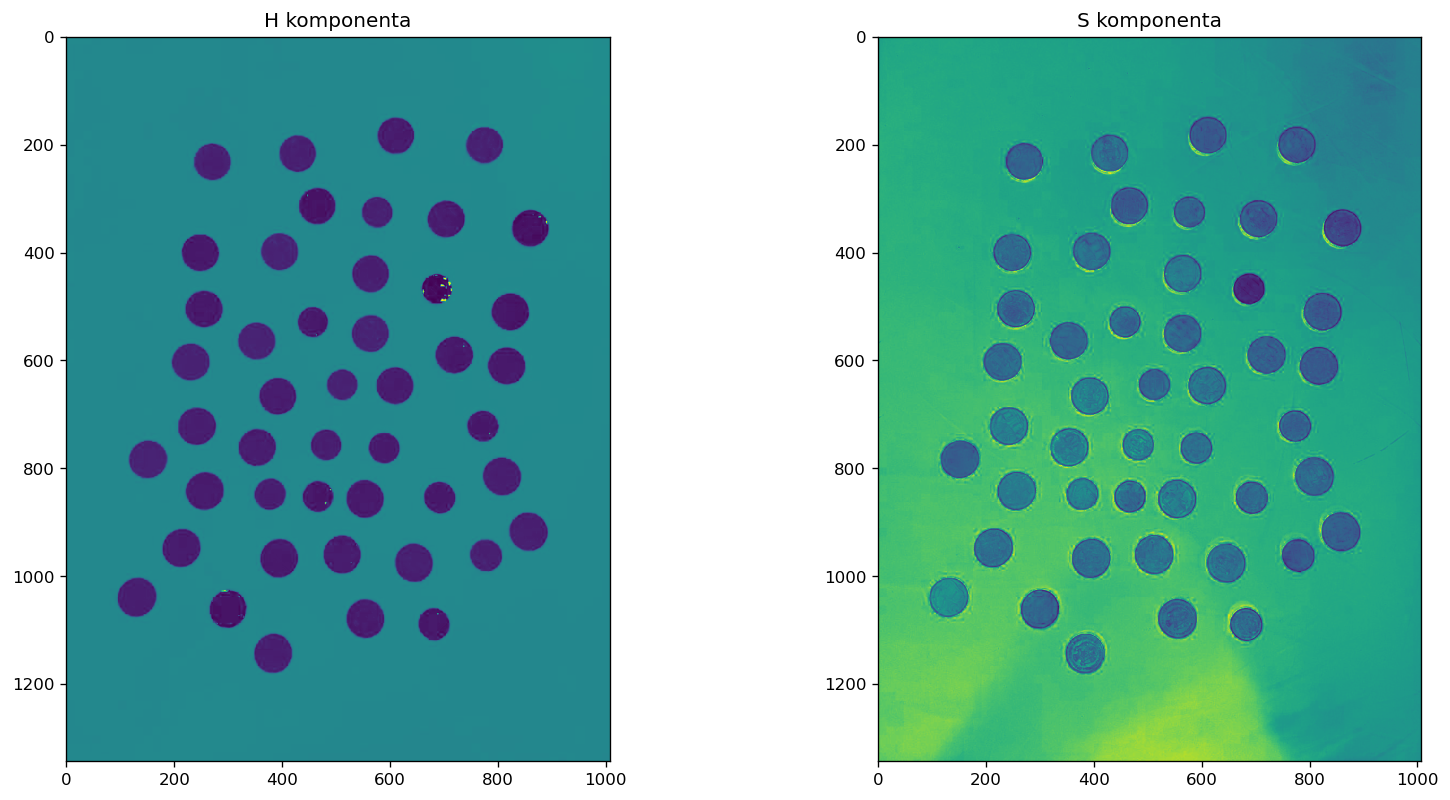

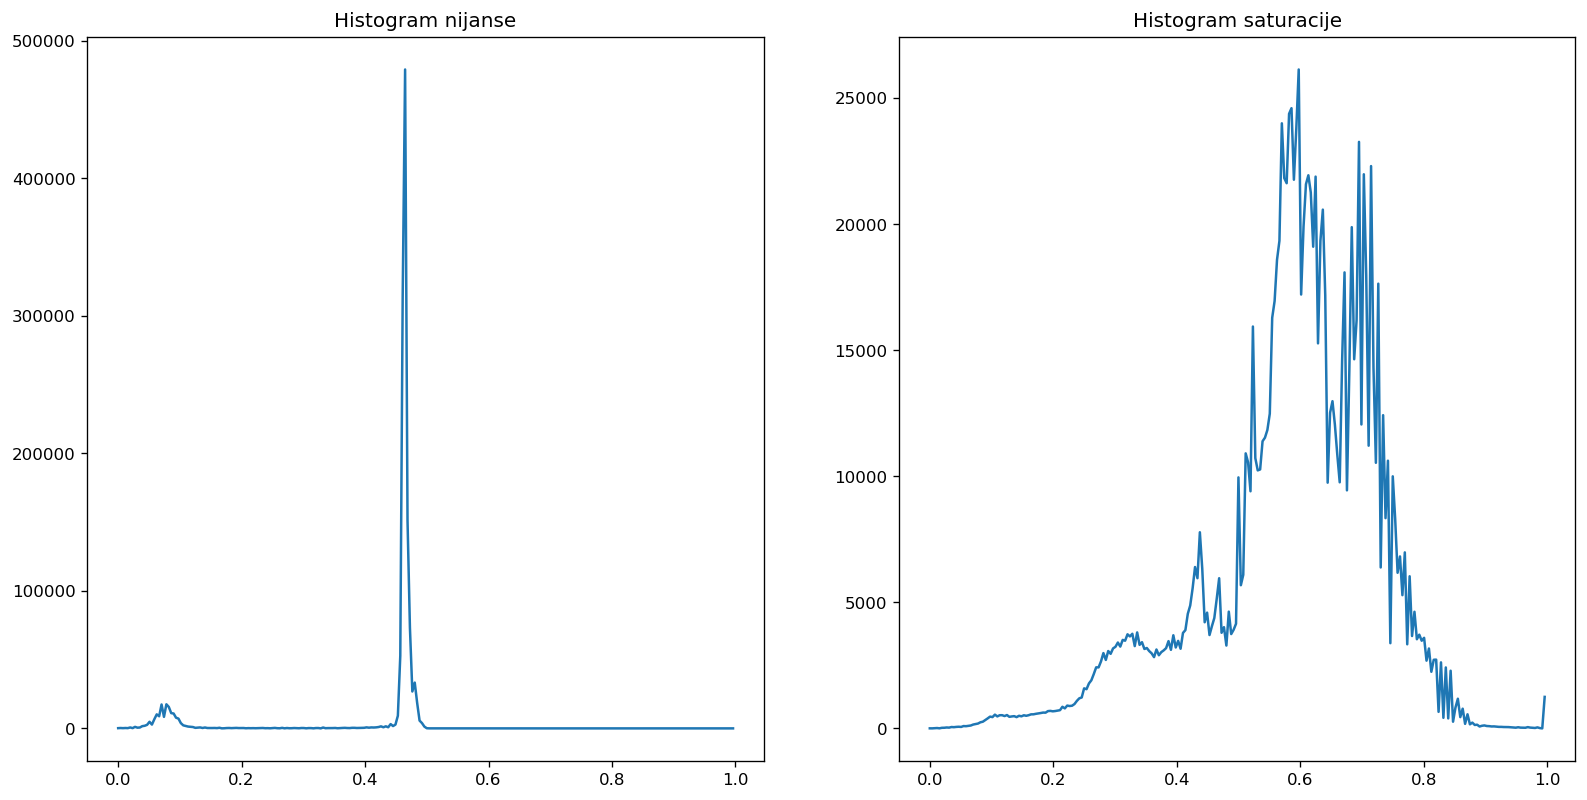

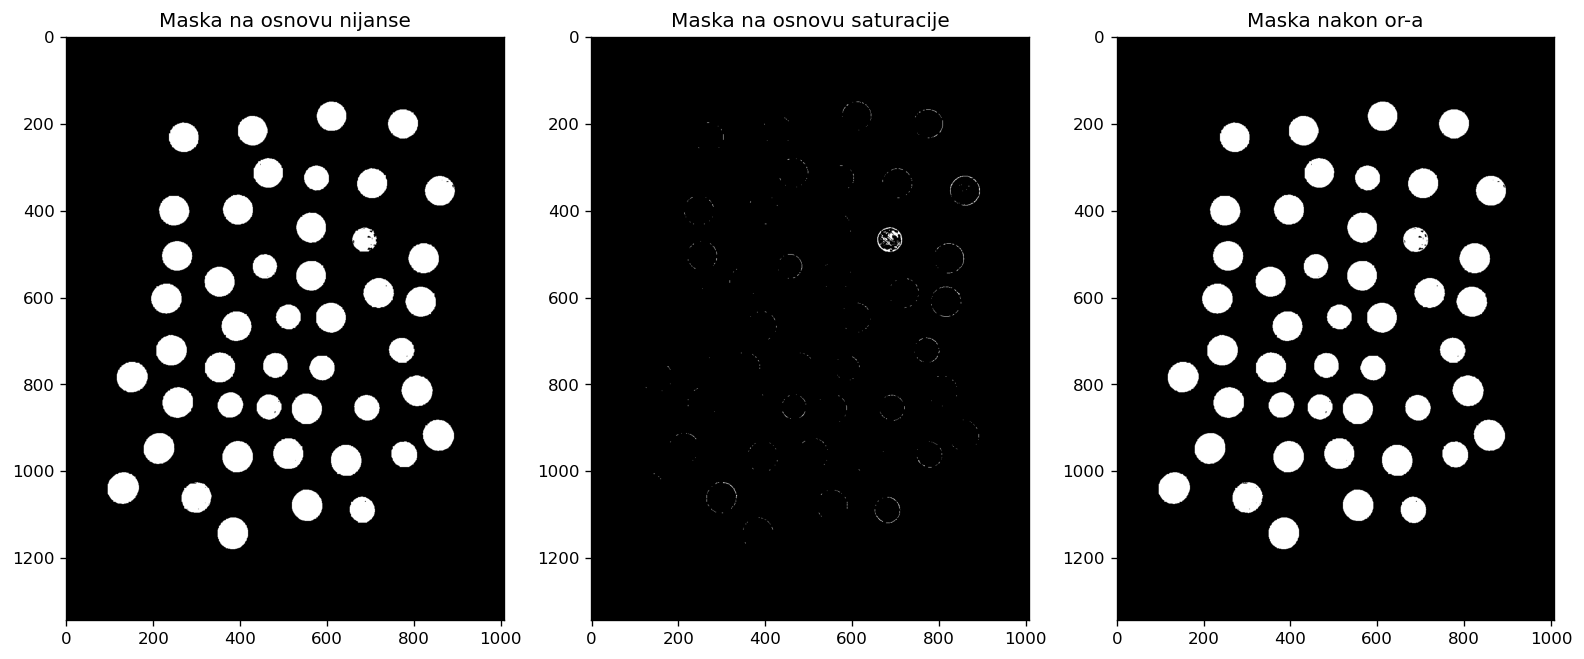

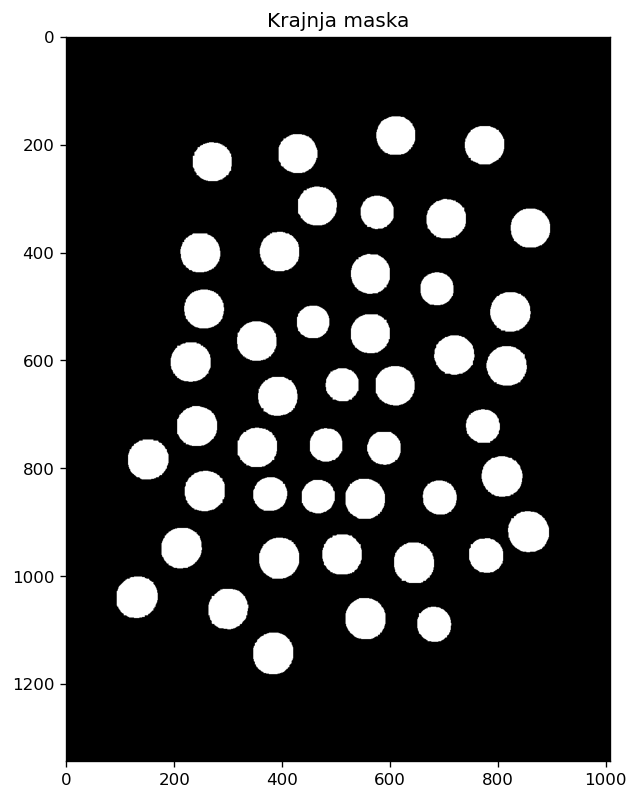

In [2]:
img_in = imread('../sekvence/coins/coins1.jpg')
img_hsv = color.rgb2hsv(img_in)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(img_hsv[:, :, 0]); ax[0].set_title('H komponenta');
ax[1].imshow(img_hsv[:, :, 1]); ax[1].set_title('S komponenta');

histogram_h, bin_h = np.histogram(img_hsv[:, :, 0].flatten(), bins=256, range=(0,1))
histogram_s, bin_s = np.histogram(img_hsv[:, :, 1].flatten(), bins=256, range=(0,1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].plot(bin_h[0:-1], histogram_h); ax[0].set_title('Histogram nijanse');
ax[1].plot(bin_s[0:-1], histogram_s); ax[1].set_title('Histogram saturacije');

# 2 classes are separated (which we can see from the histogram)
otsu_h = filters.threshold_otsu(img_hsv[:, :, 0])

mask_h = img_hsv[:, :, 0] < otsu_h

# when it comes to saturation otsu is not the best option,
# because we can not see the exact separation between 
# classes on histogram
mask_s = img_hsv[:, :, 1] < 0.1

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(mask_h*1.0, cmap='gray'); ax[0].set_title('Maska na osnovu nijanse')
ax[1].imshow(mask_s*1.0, cmap='gray'); ax[1].set_title('Maska na osnovu saturacije')

mask = logical_or(mask_h, mask_s)
ax[2].imshow(mask*1.0, cmap='gray'); ax[2].set_title('Maska nakon or-a')

# making mask wider, to get rid of the holes in coin mask.
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
mask = ndimage.correlate(mask, kernel)
mask = mask>0

# making mask narrower, to keep the shape of coins
mask = ndimage.correlate(mask, kernel)
mask = mask==1

plt.figure(figsize=(16,8), dpi=120);
plt.imshow(mask*1.0, cmap='gray'); plt.title('Krajnja maska')

Naredna funkcija coin_mask radi istu stvar kao deo koda iznad, samo bez plotova, da se ne bi svaki put plotovalo sve.

In [3]:
def coin_mask(img_in: np.array) -> np.array:
    img_hsv = color.rgb2hsv(img_in)
    
    histogram_h, bin_h = np.histogram(img_hsv[:, :, 0].flatten(), bins=256, range=(0,1))
    histogram_s, bin_s = np.histogram(img_hsv[:, :, 1].flatten(), bins=256, range=(0,1))
    
    # 2 classes are separated (which we can see from the histogram)
    otsu_h = filters.threshold_otsu(img_hsv[:, :, 0])
    mask_h = img_hsv[:, :, 0] < otsu_h
    
    # when it comes to saturation otsu is not the best option,
    # because we can not see the exact separation between 
    # classes on histogram
    mask_s = img_hsv[:, :, 1] < 0.1
    mask = logical_or(mask_h, mask_s)
    
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    mask = ndimage.correlate(mask, kernel)
    mask = mask>0
    
    mask = ndimage.correlate(mask, kernel)
    return mask==1

Labele sam pravio tako što sam prolazio kroz sve piksele i proveravao gornja tri susedna piksela i piksel levo kako bih proverio da li oni pripadaju nekoj labeli. Ukoliko pripadaju, trenutnom pikselu dodeljujem vrednost te labele, a ukoliko ne onda pravim novu lebelu za trenutni piksel. Ukoliko 2 okolna piksela imaju različite labele onda ih odmah postavljam na istu. Naravno, sve ovo radim ukoliko piksel pripada novčiću u okviru maske koja je izlaz funkcije coin_mask.

In [4]:
def bw_label(img_bin: np.array) -> np.array:
    label = np.zeros(img_bin.shape, dtype=int)
    last_ind = 1
    for_equal = []
    
    for i in range(1, img_bin.shape[0]-1):
        for j in range(1, img_bin.shape[1]-1):
            if img_bin[i, j]==True:
                if label[i-1, j-1] != 0:
                    label[i, j] = label[i-1, j-1]
                    
                if label[i-1, j] != 0 and label[i-1, j] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i-1, j]] = label[i, j]
                    else:
                        label[i, j] = label[i-1, j]
                        
                if label[i-1, j+1] != 0 and label[i-1, j+1] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i-1, j+1]] = label[i, j]
                    else:
                        label[i, j] = label[i-1, j+1]
                
                if label[i, j-1] != 0 and label[i, j-1] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i, j-1]] = label[i, j]
                    else:
                        label[i, j] = label[i, j-1]
                    
                if label[i, j] == 0:
                    label[i, j] = last_ind
                    last_ind = last_ind+1
    return label

U sledećem delu koda pokazujem kako radi ova funkcija. Različite labele sam obojio drugom bojom.

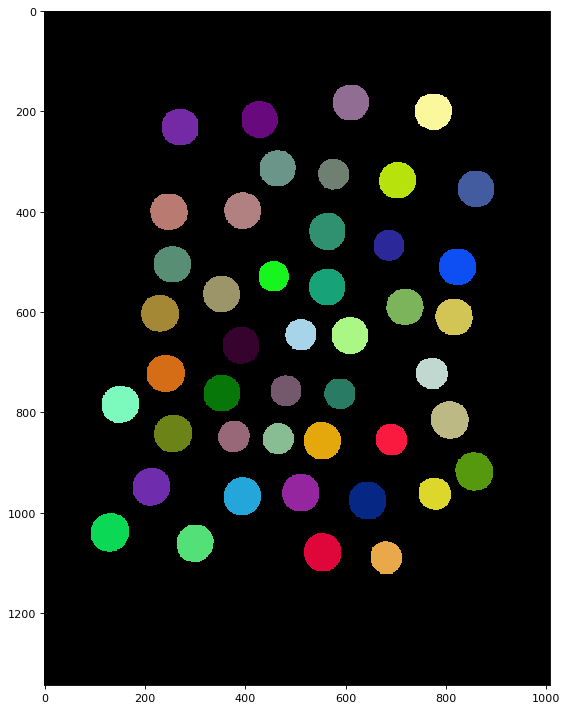

In [5]:
mask = coin_mask(img_in)
label = bw_label(mask)
random.seed(10)
    
img_colored = np.zeros((label.shape[0], label.shape[1], 3), dtype=float)

for i in range(1, np.max(label)):
    r = random.random()
    g = random.random()
    b = random.random()
    img_colored[label == i, 0] = r
    img_colored[label == i, 1] = g
    img_colored[label == i, 2] = b

plt.figure(figsize=(12, 9), dpi=80)
io.imshow(img_colored)

U funkciji coin_classification sam samo pozvao obe funkcije coin_mask i bw_label. Nakon toga sam izbrojao koliko ima elemenata iz svake labele i na osnovu broja piksela koji pripadaju labeli sam klasifikovao novčiće. Za granični broj sam koristio otsu-ovu granicu. Takođe predstavio sam sliku gde prikazujem novčiće koji su klasifikovani u klasu 1 (crveni) i u klasu 2 (zeleni).

In [6]:
def coin_classification(img_in: np.array) -> tuple:
    mask = coin_mask(img_in)
    label = bw_label(mask)
    
    maks = np.max(label)
    hist = np.zeros(maks, dtype=int)
    for i in range(1, maks+1):
        hist[i-1] = np.sum(label==i)
    ind = hist>0
    otsu = filters.threshold_otsu(hist[ind])
    r1 = 0.7
    g1 = 0.2
    b1 = 0.2
    
    r2 = 0.2
    g2 = 0.7
    b2 = 0.2
    img_out = np.zeros((label.shape[0], label.shape[1], 3), dtype=float)
    
    for i in range(1, maks+1):
        img = label == i
        suma = np.sum(img)
        if suma != 0 and suma <=otsu:
            img_out[img, 0] = r1
            img_out[img, 1] = g1
            img_out[img, 2] = b1
        if suma>otsu:
            img_out[img, 0] = r2
            img_out[img, 1] = g2
            img_out[img, 2] = b2
            
    ax[1].imshow(img_out); ax[1].set_title('Klasifikacija novčića');
    
    return np.sum(hist[ind]<=otsu), np.sum(hist[ind]>otsu)

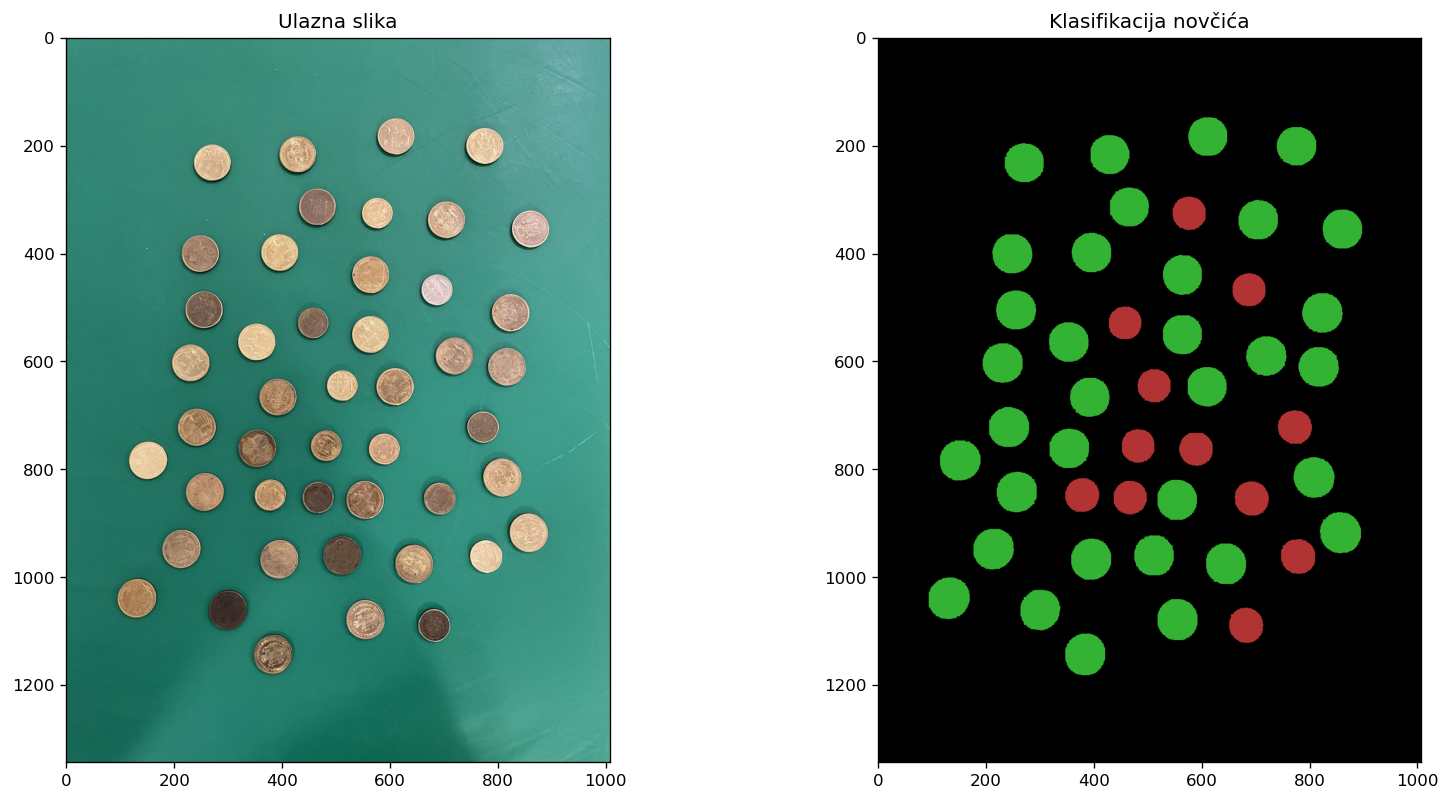

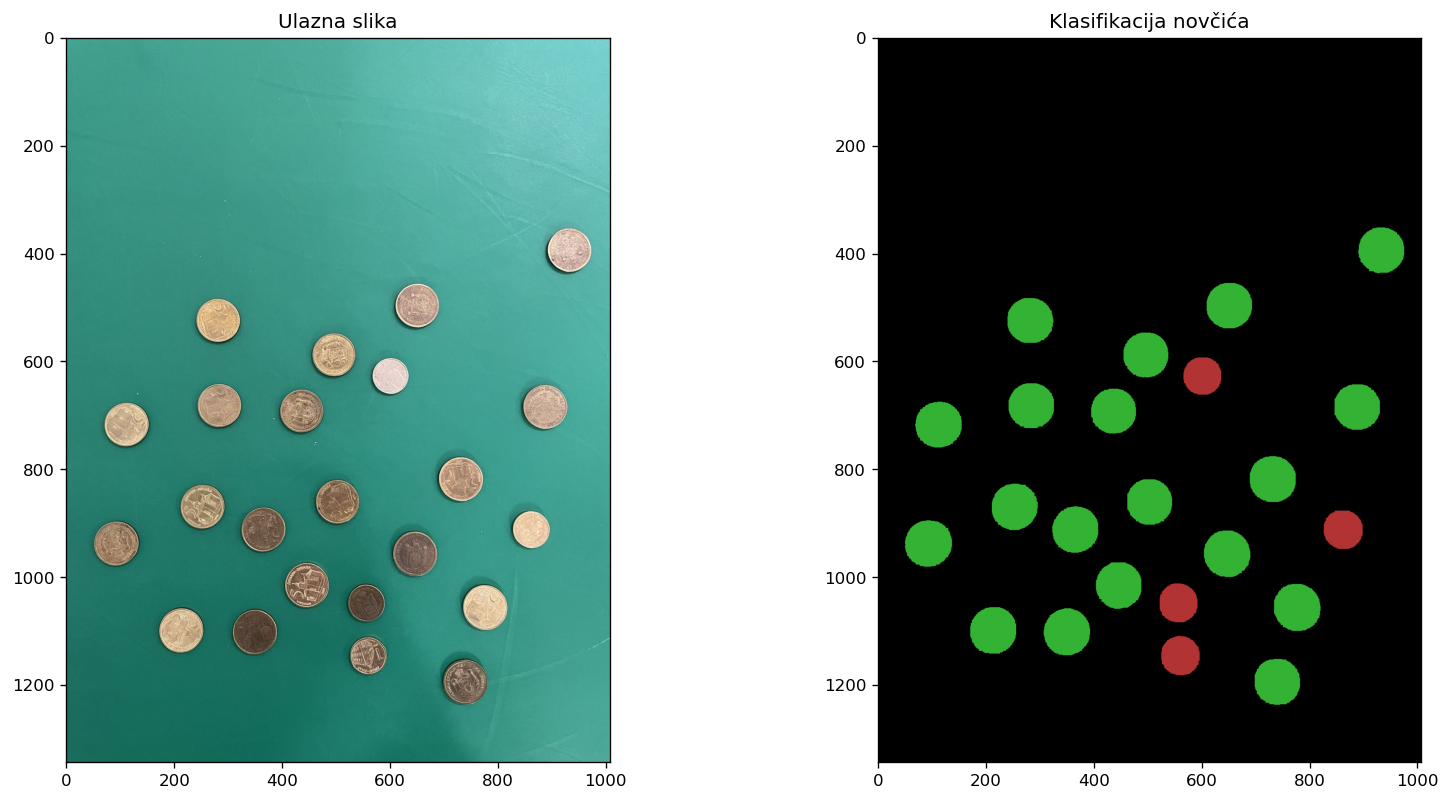

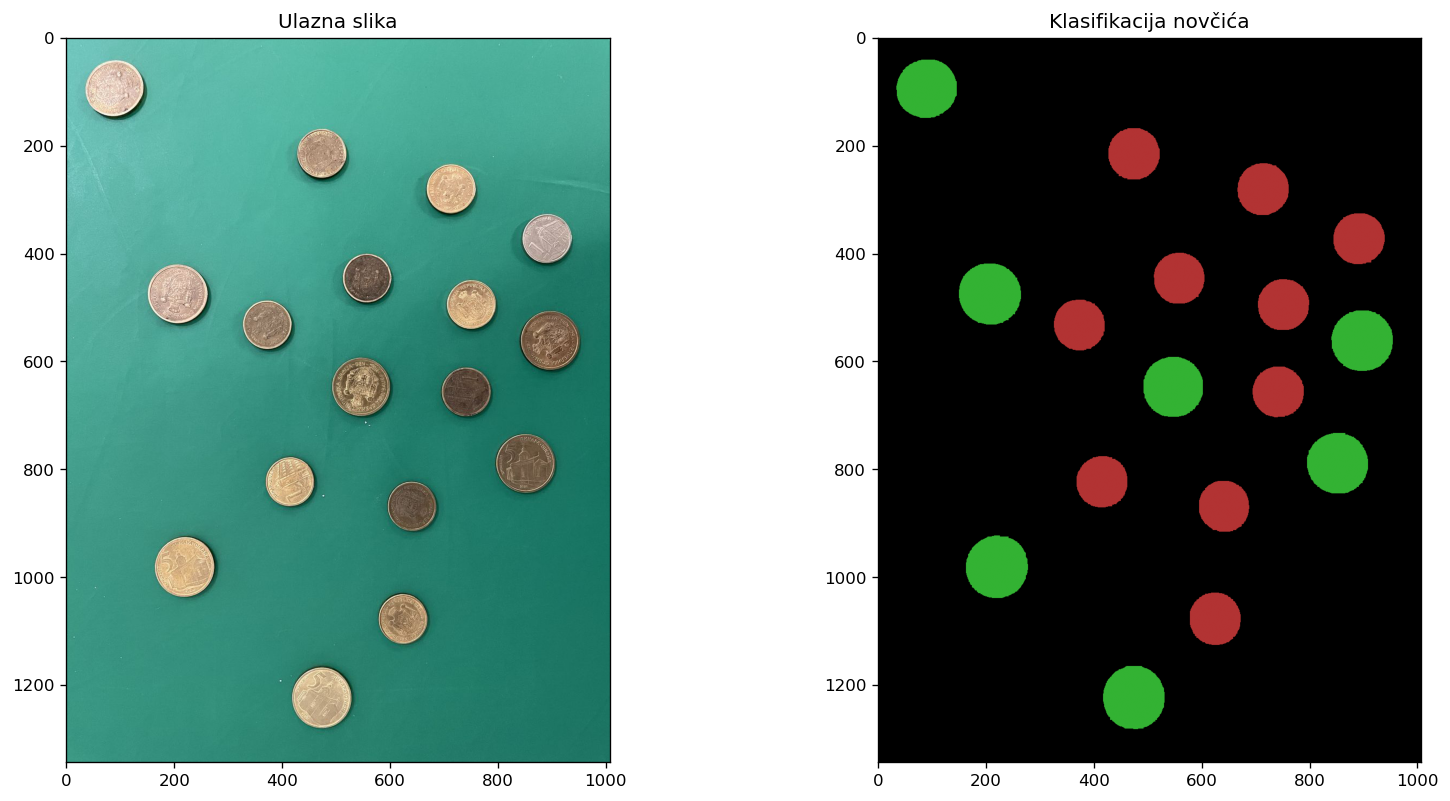

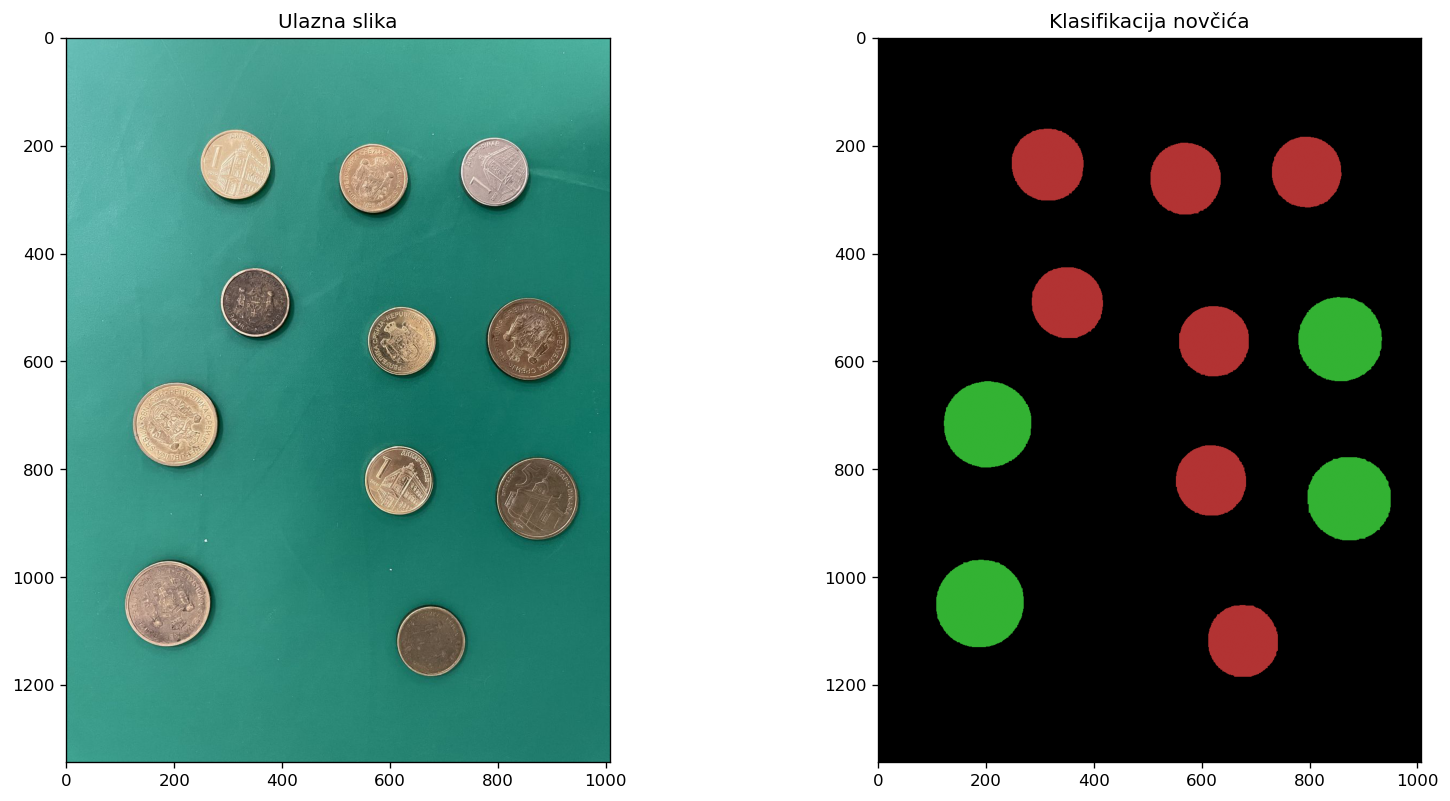

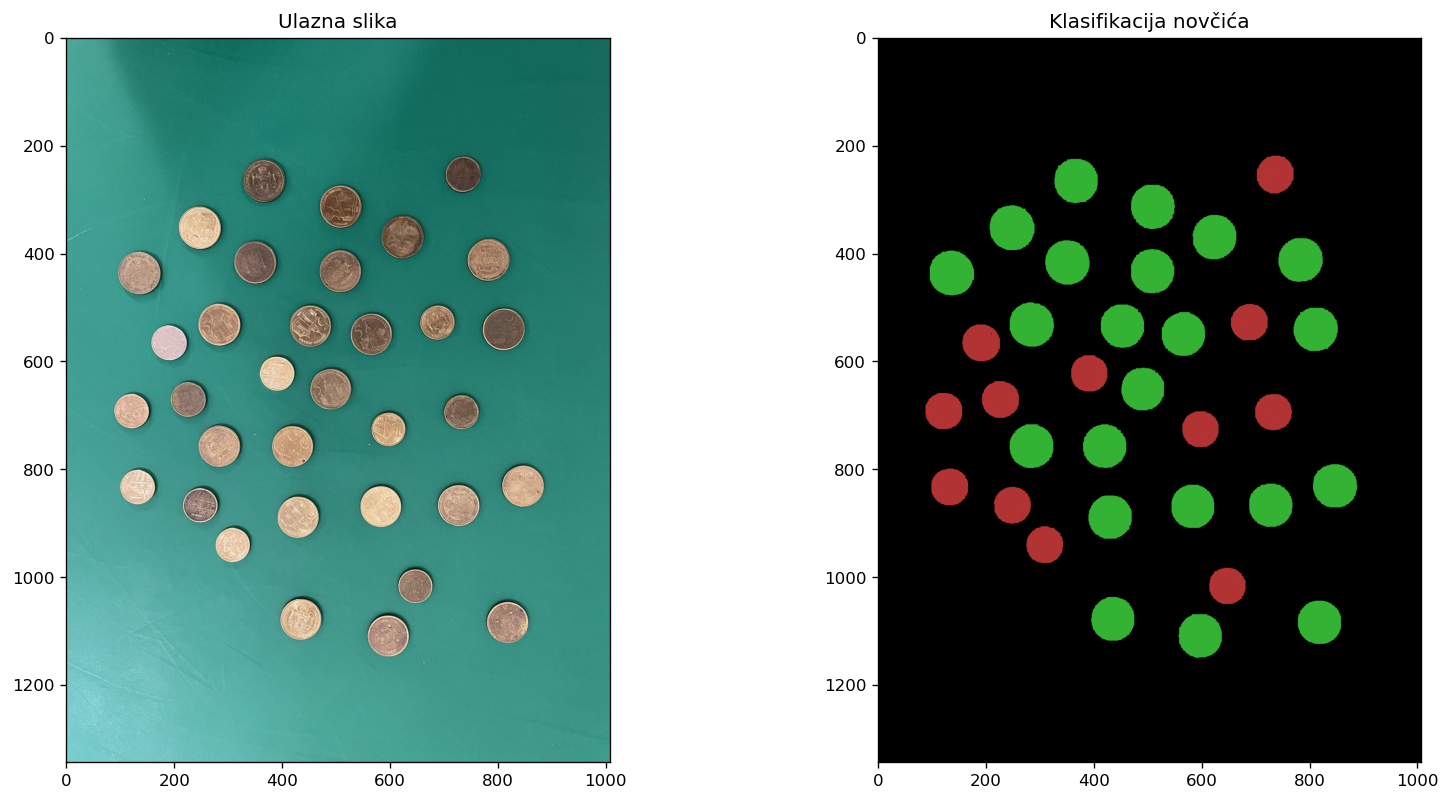

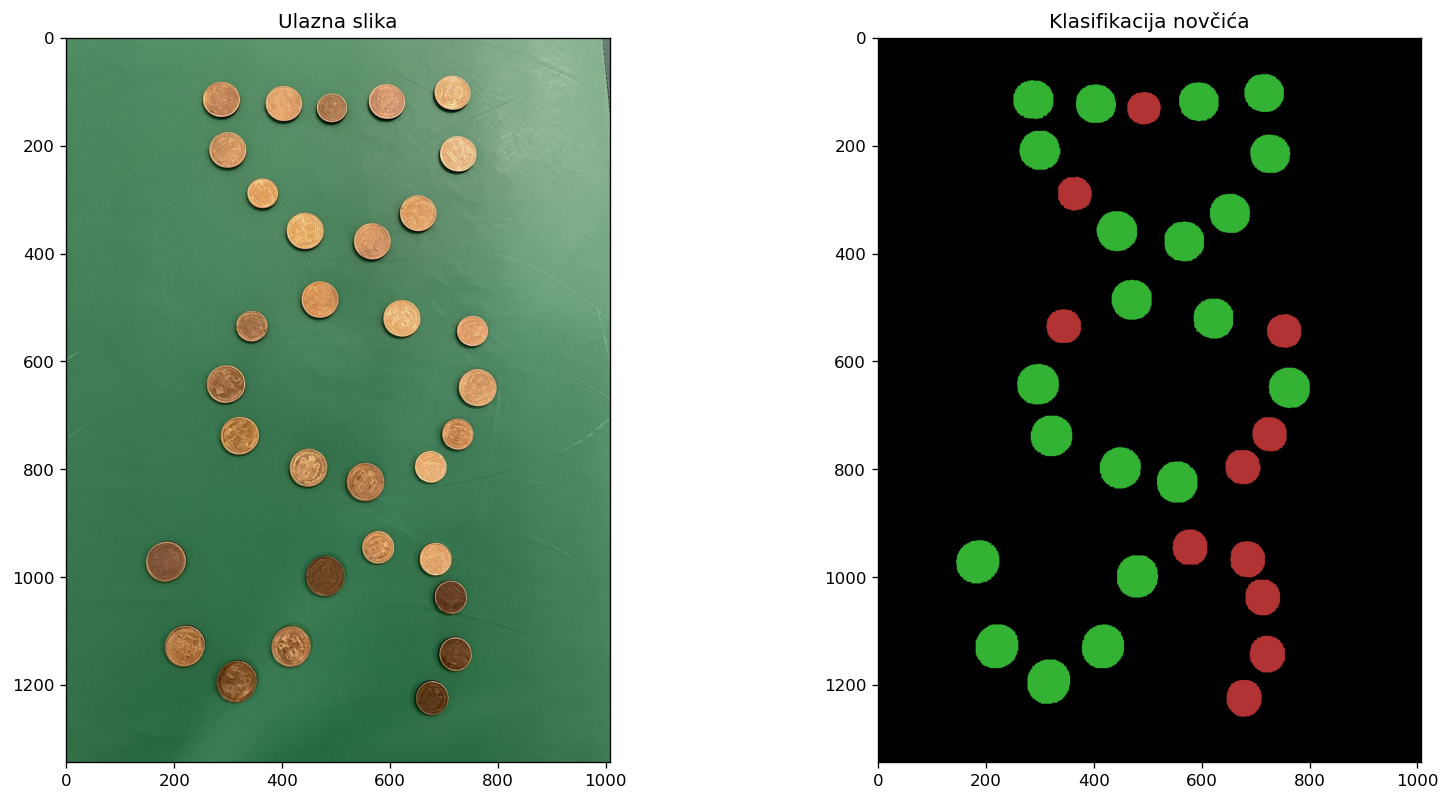

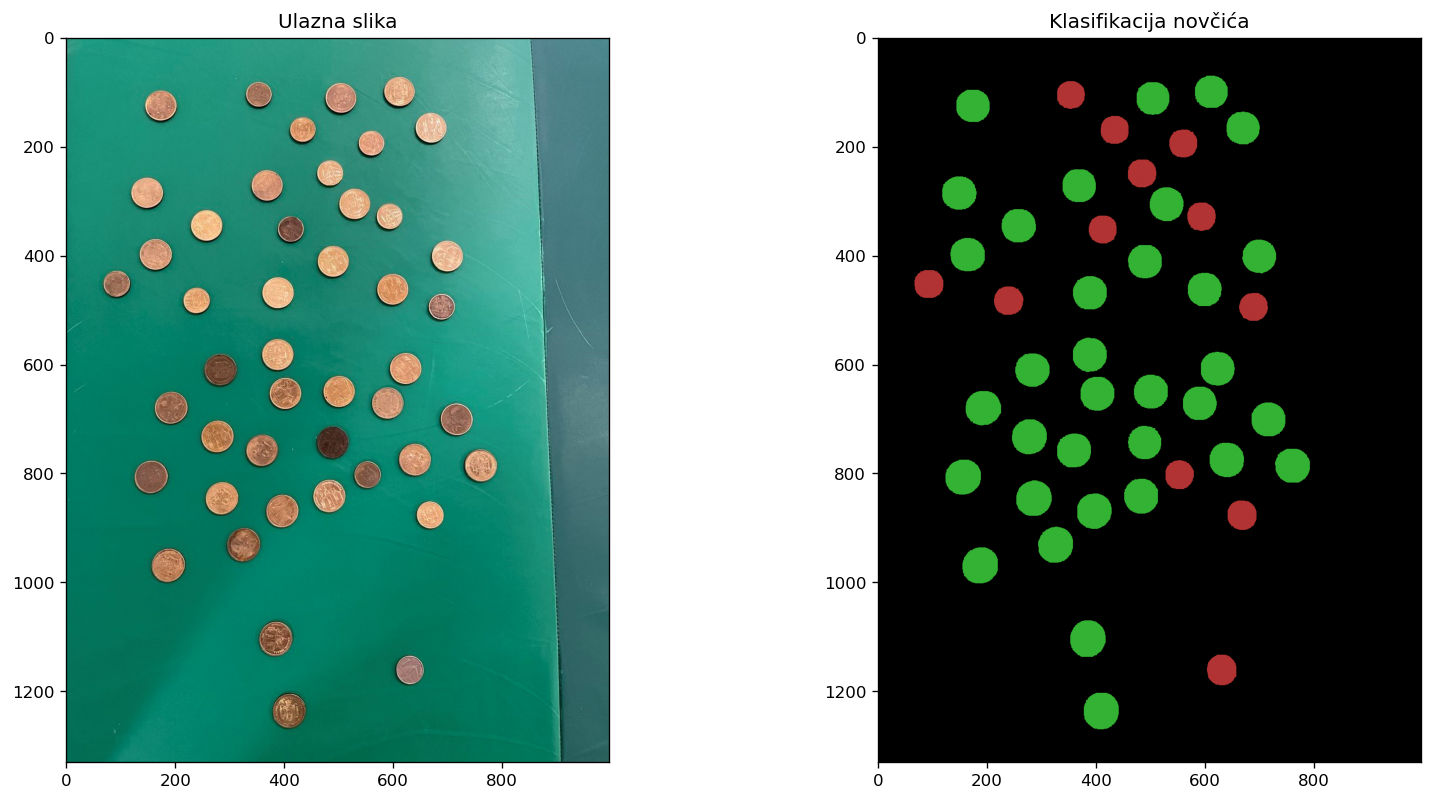

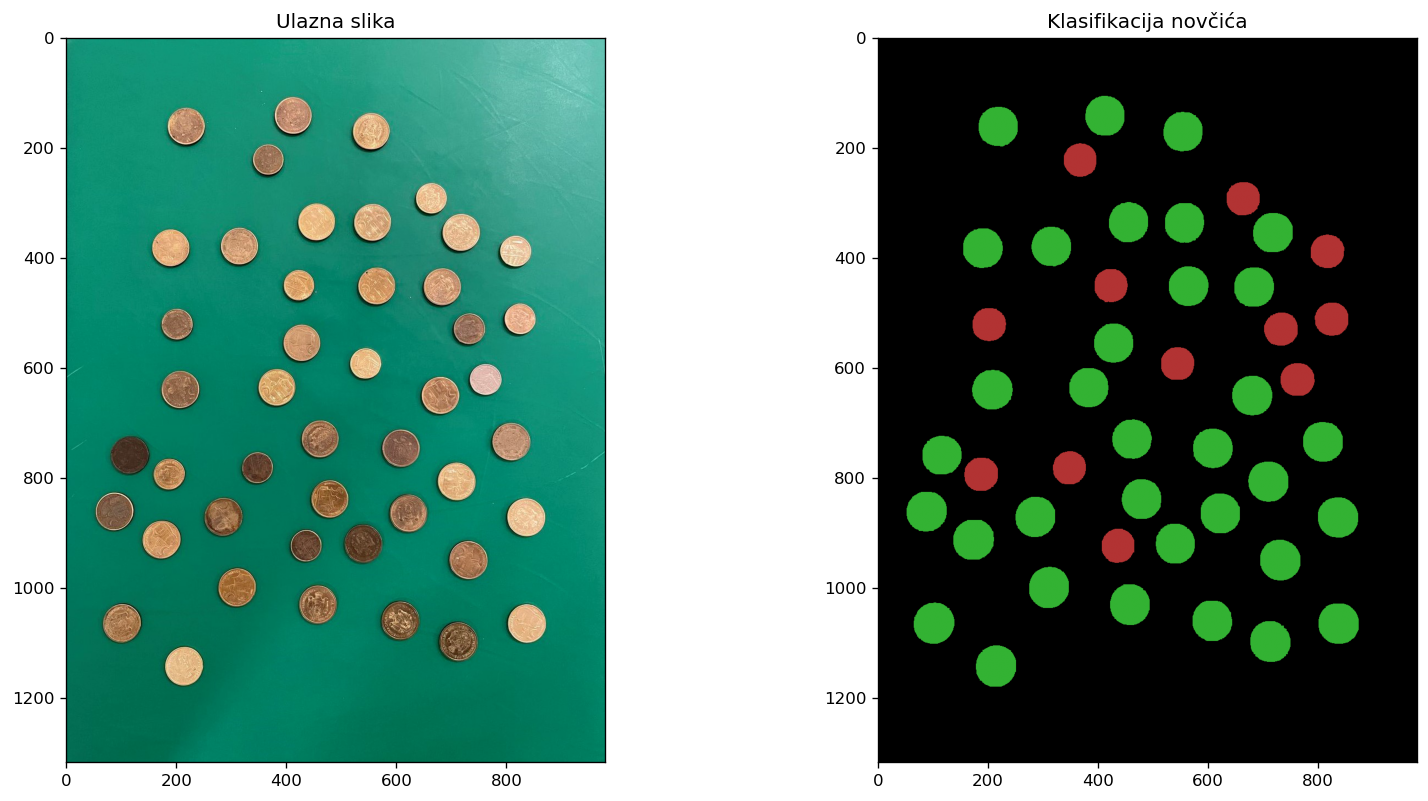

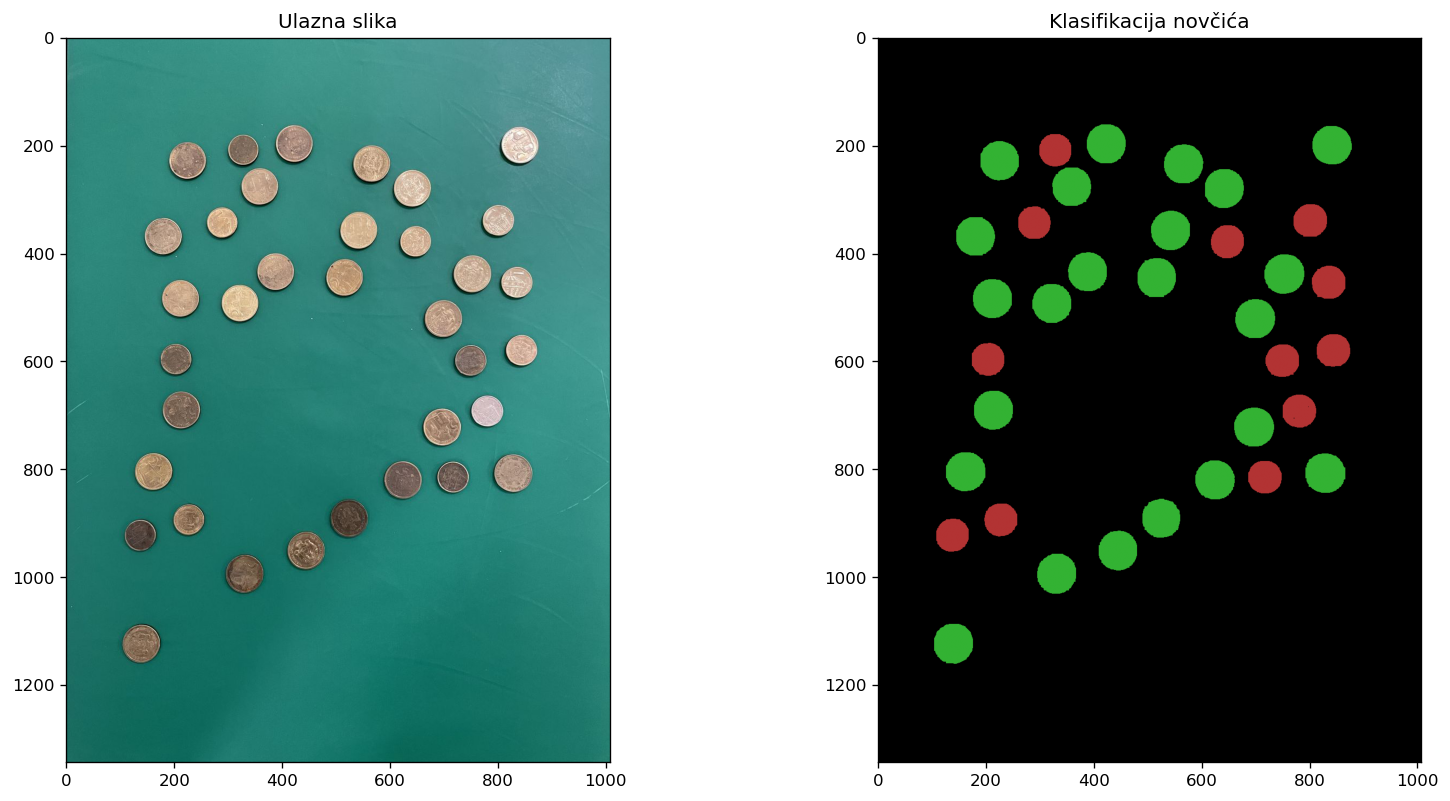

In [12]:
file_path = '../sekvence/coins/coins'
table =[['Slika', 'Klasa 1', 'Klasa 2', 'Ukupno']]
for image_num in range(1, 10):
    name = file_path + str(image_num) + '.jpg'
    img_in = imread(name)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
    ax = axes.ravel()
    ax[0].imshow(img_in); ax[0].set_title('Ulazna slika');
    k1, k2 = coin_classification(img_in)
    table = table + [['coins' + str(image_num) + '.jpg', str(k1), str(k2), str(k1+k2)]]

Evo prikaza rezultata nad svim slikama i kao što vidimo rezultati su dobri na svim slikama.

In [15]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤═══════════╤═══════════╤══════════╕
│ Slika      │   Klasa 1 │   Klasa 2 │   Ukupno │
╞════════════╪═══════════╪═══════════╪══════════╡
│ coins1.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins2.jpg │         4 │        19 │       23 │
├────────────┼───────────┼───────────┼──────────┤
│ coins3.jpg │        10 │         7 │       17 │
├────────────┼───────────┼───────────┼──────────┤
│ coins4.jpg │         7 │         4 │       11 │
├────────────┼───────────┼───────────┼──────────┤
│ coins5.jpg │        12 │        22 │       34 │
├────────────┼───────────┼───────────┼──────────┤
│ coins6.jpg │        11 │        21 │       32 │
├────────────┼───────────┼───────────┼──────────┤
│ coins7.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins8.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins9.jpg │        12 │        23 │       35 │
